# Week 8 (Aaron Kohn)
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

## Exercise 9-1

In [1]:
import numpy as np

#import random

import thinkstats2
import thinkplot

In [2]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [3]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [4]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [5]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['prglngth', 'totalwgt_lb'])


In [6]:
x= len(live)
a=['Sample size','Mean test','Chi test','Correlation test']
print(f'{a[0]:<15} {a[1]:<15} {a[2]:<15} {a[3]:<15}')
while x > 600:
    x -= 500
    live = thinkstats2.SampleRows(live, nrows= x )
    firsts = live[live.birthord == 1]
    others = live[live.birthord > 1]
    data = firsts.prglngth.values, others.prglngth.values
    dm = DiffMeansPermute(data)
    pv_dm = dm.PValue()
    chi_sq = PregLengthTest(data)
    pv_cs = chi_sq.PValue()

    data = live.agepreg.values, live.totalwgt_lb.values
    corp = CorrelationPermute(data)
    pv_cor = corp.PValue()
    print(f'{len(live):<15}{pv_dm:<15}{pv_cs:<15} {pv_cor:<15}')

Sample size     Mean test       Chi test        Correlation test
8538           0.102          0.0             0.0            
8038           0.034          0.0             0.0            
7538           0.02           0.0             0.0            
7038           0.006          0.0             0.0            
6538           0.014          0.0             0.0            
6038           0.044          0.0             0.0            
5538           0.098          0.0             0.0            
5038           0.032          0.0             0.0            
4538           0.044          0.0             0.0            
4038           0.022          0.0             0.0            
3538           0.068          0.0             0.0            
3038           0.024          0.0             0.001          
2538           0.17           0.0             0.002          
2038           0.051          0.0             0.063          
1538           0.038          0.0             0.014          
1038 

## Exercise 10-1

In [7]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0


In [8]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)
inter,slope

(0.9930804163918064, 0.005281454169417842)

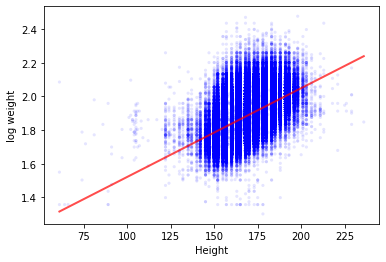

In [9]:
thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height",
                 ylabel='log weight',
                 legend=False)

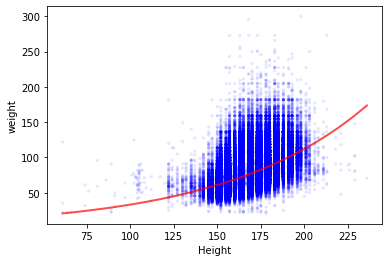

In [10]:
thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10 ** fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height",
                 ylabel='weight',
                 legend=False)


In [11]:
# Generate model from none log transformed data
inter1, slope1 = thinkstats2.LeastSquares(heights, weights)
fit_xs1, fit_ys1 = thinkstats2.FitLine(heights, inter1, slope1)

In [12]:
10 ** (np.mean(heights) * slope + inter), np.mean(heights) * slope1 + inter1

(76.80947249428195, 79.04441343803799)

Above calculates the predicted weight for the mean height, using the $log_{10}$ model and the standard model.

In [13]:
10 ** slope, slope1

(1.0122352432332076, 0.9570745850332383)

When reportin the findings of a log transformed data set an understanding of logarithms would be necessary. A basic example using a transformation can be used as above, but a more accurate result would be reached when using the log scale.

In [14]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [15]:
df['log_res'] = Residuals(heights, log_weights, inter, slope)
df['res'] = Residuals(heights, weights, inter1, slope1)

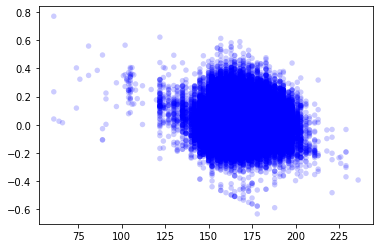

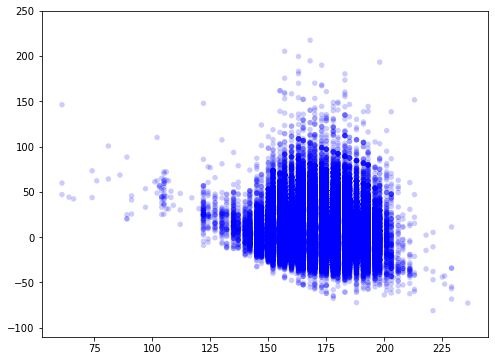

<Figure size 576x432 with 0 Axes>

In [16]:
# Residual plots
thinkplot.Scatter(heights, df.log_res, alpha= .2)
thinkplot.show()
thinkplot.Scatter(heights, df.res, alpha= .2)
thinkplot.Show(ylim= [-110,250])

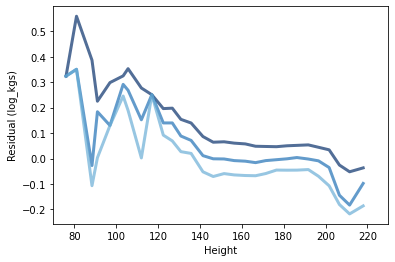

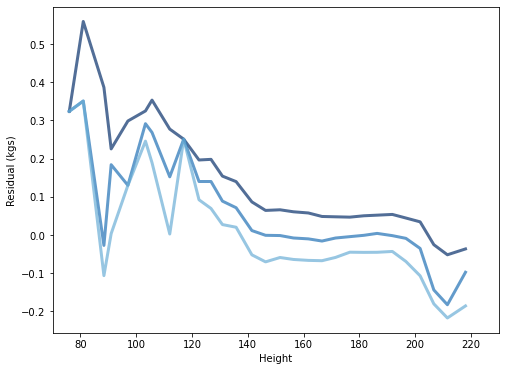

In [17]:
# plot percentiles for log model and linear model
bins = np.arange(75, 225, 5)
indices = np.digitize(heights, bins)
groups = df.groupby(indices) 
height_means = [group.htm3.mean() for _, group in groups][1:-1]
log_cdfs = [thinkstats2.Cdf(group.log_res) for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.log_res) for _, group in groups][1:-1]
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)
PlotPercentiles(height_means,log_cdfs)
thinkplot.Show(xlabel="Height",
                 ylabel='Residual (log_kgs)',
                 xlim=[70, 230])
PlotPercentiles(height_means,cdfs)
thinkplot.Config(xlabel="Height",
                 ylabel='Residual (kgs)',
                 xlim=[70, 230])


In [18]:
thinkstats2.Corr(heights,log_weights)#,thinkstats2.Corr(heights,weights)

0.5317282605983464

In [19]:
thinkstats2.CoefDetermination(log_weights, df.log_res), thinkstats2.Corr(heights,log_weights) ** 2

(0.2827349431189352, 0.28273494311894304)

In [20]:
RMSE = thinkstats2.Std(log_weights) 
RMSE_res = thinkstats2.Std(df.log_res)
RMSE, RMSE_res

(0.10320725030004853, 0.08740777080416083)

In [21]:
1 - RMSE_res / RMSE

0.1530849765879313

Height accounts for 28.273% of change in weight, and reduces RMSE by .153 (log transformed kgs).

In [22]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [23]:
iters = 50
estimates = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(iters)]

In [24]:
estimates_rewgt = [ResampleRowsWeighted(df, column = 'finalwt').htm3.mean() for _ in range(iters)]

In [25]:
def Summarize(estimates, actual=None):
    mean = np.mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [26]:
Summarize(estimates)

mean, SE, CI 168.95519796277208 0.01616098760975727 (168.9310389256048, 168.9823662563916)


In [27]:
Summarize(estimates_rewgt)

mean, SE, CI 170.49693632652236 0.018848850798257794 (170.46050849855493, 170.52348976333394)


The mean height increases by 2 cm when taking sample weights into account. This change is much larger than the standard error of the samples.